# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
# train test split
from sklearn.model_selection import train_test_split
import utils

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Read data

In [2]:
data_path = os.getcwd()+"\data\BreastCancer1.csv"
data = pd.read_csv(data_path, sep=',', header=0, index_col=0)

data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


# Data preprocessing


In [3]:
## label and features separation

diagnosis = data['diagnosis']
data = data.drop('diagnosis', axis=1)


## Remove correlated variables

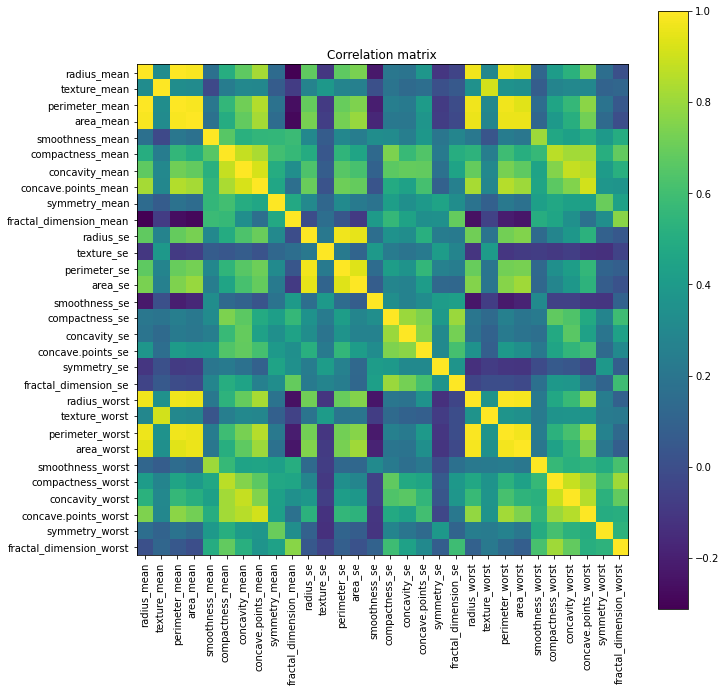

In [4]:
# correlation matrix plot
utils.correlation(data)

Mean and worst variables are correlated, so we can drop the worst variables worst is the worst average value of the 3 largest cells, so it makes sense to be correlated with mean.

* Also radious, area and perimeter are correlated, because cells are quite circular.

* Concavity, concave_points and compactness are quite correlated as well.

* Lets drop correlated columns to avoid colineality that can mess up the hole analysis.

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'smoothness_se', 'compactness_se', 'symmetry_se',
       'fractal_dimension_se'],
      dtype='object')


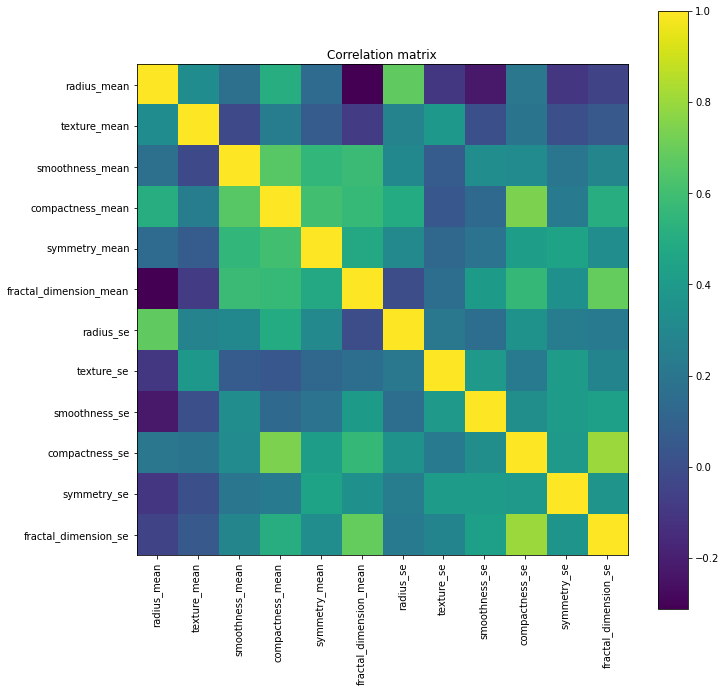

In [5]:
# search the correlated columns
worst_columns = [col for col in data.columns if 'worst' in col]
perimeter_area_columns = [col for col in data.columns if 'perimeter' in col or 'area' in col]
concavity_columns = [col for col in data.columns if 'concavity_' in col or 'concave.points_' in col]

# drop correlated columns
drop_columns = worst_columns + perimeter_area_columns + concavity_columns
data.drop(drop_columns, axis=1, inplace=True)

print(data.columns)
utils.correlation(data)

# Outliers search

In this case I have used the interquartile range method, but there are other less strict methods.

These values may distort subsequent analyses, or may be clear indicators of cancer. It would be usefull try the analysis with and without them.

To speed up the presentation in this case I will keep the outliers because I do not think it is appropriate to remove the larger cells or cells with larger size deviations, I suspect that they are good indicators that something is wrong.

In [6]:
# outliers detection
utils.detect_outliers(data)

{'radius_mean': 14,
 'texture_mean': 7,
 'smoothness_mean': 6,
 'compactness_mean': 16,
 'symmetry_mean': 15,
 'fractal_dimension_mean': 15,
 'radius_se': 38,
 'texture_se': 20,
 'smoothness_se': 30,
 'compactness_se': 28,
 'symmetry_se': 27,
 'fractal_dimension_se': 28}

# data normalization?



I will not normalize the data because doing so would cause the larger values to lose influence on the model. In this case, the larger values appear to be good indicators of cancer.

# Exploratory Data Analysis

In [7]:
# there are no missing values
print("null values: ", data.isnull().values.sum())
print("na values: ", data.isna().values.sum())

null values:  0
na values:  0


B    357
M    212
Name: diagnosis, dtype: int64


<AxesSubplot:title={'center':'Diagnosis'}>

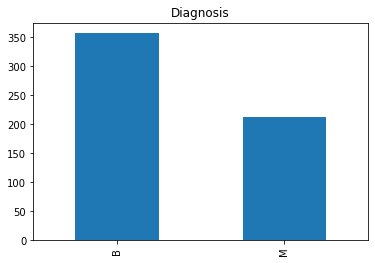

In [8]:
# there are way more benign than malignant cases, be aware of this
print(diagnosis.value_counts())
# barplot of diagnosis
diagnosis.value_counts().plot(kind='bar', title='Diagnosis')

<AxesSubplot:xlabel='radius_mean', ylabel='diagnosis'>

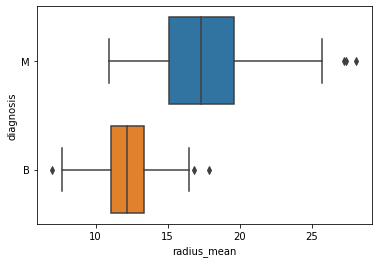

In [9]:

# as we expected, the radius_mean is way bigger and heterogeneous in malignant tumors, outliers included
sns.boxplot( x=data["radius_mean"], y=diagnosis)

<AxesSubplot:xlabel='radius_se', ylabel='diagnosis'>

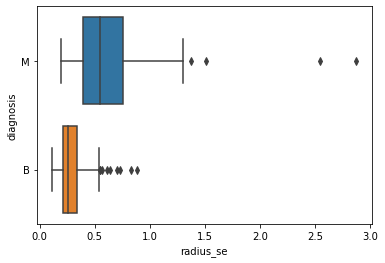

In [10]:
sns.boxplot( x=data["radius_se"], y=diagnosis)

## PCA
* we can see that most malignant cases are clearly distinguishable from benign ones.

* But there are malignant ones that in the PCA are surrounded by benign cases, these are the most dangerous cases because we could diagnose them as benign and leave a patient with cancer without treatment.

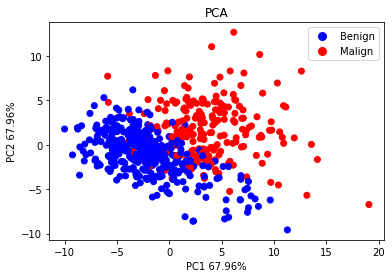

In [11]:
utils.pca_analysis(data, diagnosis)

# Clasification with KNN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, diagnosis, test_size=0.2, random_state=123)
X_train.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,fractal_dimension_se
id,,,,,,,,,,,,
874858,14.22,23.12,0.10750,0.24130,0.2384,0.07542,0.2860,2.1100,0.007970,0.135400,0.05113,0.011720
867739,18.45,21.91,0.09430,0.09709,0.1692,0.05727,0.5959,1.2020,0.006001,0.014220,0.01492,0.002205
902975,12.21,14.09,0.08108,0.07823,0.1646,0.06154,0.2666,0.8309,0.004405,0.030260,0.01921,0.004622
864877,15.78,22.91,0.11550,0.17520,0.2096,0.07331,0.5520,1.0720,0.008699,0.039760,0.01495,0.005984
894090,12.18,14.08,0.07734,0.03212,0.1673,0.05649,0.2113,0.5996,0.005343,0.005767,0.01977,0.000950


In [13]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 30)}
recall_scorer = make_scorer(recall_score, pos_label='M')

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring=recall_scorer)

grid_search_knn.fit(X_train, y_train)

print("Best parameters: ", grid_search_knn.best_params_)
print("Best sensitivity: ", grid_search_knn.best_score_)


Best parameters:  {'n_neighbors': 1}
Best sensitivity:  0.8188235294117646


That's a pretty bad prediction, 1 in 5 cancer patients would go home with a negative test.
A k=1 means that each patient is predicted acording to the most similar one. 

## Test prediction and validation
Lets predict with this model and see the final result with a dataset never seen by the model

Accuracy: 0.868
Recall: 0.756


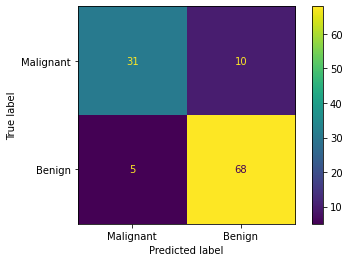

In [14]:
# train the model with the best parameters
knn = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'])
predictions = knn.fit(X_train, y_train).predict(X_test)

utils.validation(y_test, predictions)


In [15]:
# sensitivity or recall is calculated this way
31/41

0.7560975609756098

# Clasification with support vector machines (SVM)

In [16]:
svc = SVC()
param_grid = {'C': [0.1, 1, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'rbf']}
recall_scorer = make_scorer(recall_score, pos_label='M')

grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring=recall_scorer)
grid_search_svc.fit(X_train, y_train)

print("Best parameters: ", grid_search_svc.best_params_)
print("Best sensitivity: ", grid_search_svc.best_score_)


Best parameters:  {'C': 1000, 'gamma': 1, 'kernel': 'linear'}
Best sensitivity:  0.8825210084033612


Accuracy: 0.939
Recall: 0.878


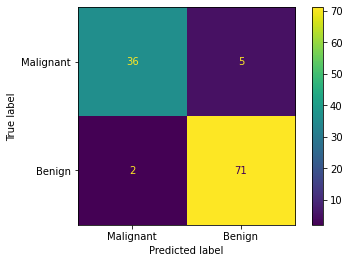

In [17]:
# Evaluate the model
svc = SVC(
    C=grid_search_svc.best_params_['C'],
    gamma=grid_search_svc.best_params_['gamma'],
    kernel=grid_search_svc.best_params_['kernel']
                                       )

predictions = svc.fit(X_train, y_train).predict(X_test)
utils.validation(y_test, predictions)


With this model, much more complex than knn, we get better results (the number of false negatives is reduced by half), but specificity is not good enough.

we could try to put in param_grid higher values of C since the one we have is the highest value of the tested ones. we could also try to tune a little more in gamma. For now there seems to be no overfitting problems because the sensitivity of the train and test datasets are similar.

# Clasification with random forest

In [18]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 30, 50, 70, 100, 200, 500], 
                               'max_depth': [2, 3, 5, 10, 20, 50, 100]}

grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring=recall_scorer)
grid_search_rf.fit(X_train, y_train)

print("Best parameters: ", grid_search_rf.best_params_)
print("Best sensitivity: ", grid_search_rf.best_score_)


Best parameters:  {'max_depth': 10, 'n_estimators': 200}
Best sensitivity:  0.8768067226890756


Accuracy: 0.939
Recall: 0.878


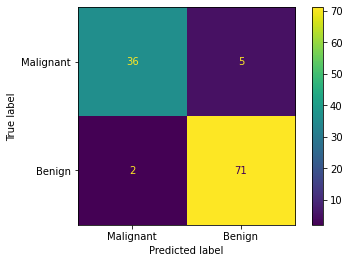

In [19]:
# Evaluate the model
rf = RandomForestClassifier(
    n_estimators=grid_search_rf.best_params_['n_estimators'],   
    max_depth=grid_search_rf.best_params_['max_depth']
)

predictions = rf.fit(X_train, y_train).predict(X_test)
utils.validation(y_test, predictions)


# Clasification with neural network (Keras)

In [20]:
# diagnosis as M and B causes a lot of problems, so we will change it to 1 and 0
diagnosis = diagnosis.map({'M': 1, 'B': 0})
X_train, X_test, y_train, y_test = train_test_split(data, diagnosis, test_size=0.2, random_state=123)

In [21]:
import tensorflow as tf
from tensorflow import keras


# Simple neuronal network
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_shape=(
    X_train.shape[1],), activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Create a checkpoint callback
checkpoint_path = "best_model"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_best_only=True)

with tf.device('/GPU:0'): # trained on GPU
    history = model.fit(X_train, y_train, epochs=200,
                        batch_size=16, validation_split=0.2, callbacks=[checkpoint])


c:\Users\rashb\AppData\Local\Programs\Python\Python38\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Epoch 1/200
23/23 [==============================] - 4s 130ms/step - loss: 1.0709 - accuracy: 0.4890 - val_loss: 0.7085 - val_accuracy: 0.5934
Epoch 2/200
23/23 [==============================] - 2s 102ms/step - loss: 0.8703 - accuracy: 0.5549 - val_loss: 0.6898 - val_accuracy: 0.5714
Epoch 3/200
23/23 [==============================] - 0s 11ms/step - loss: 0.8001 - accuracy: 0.5879 - val_loss: 0.7077 - val_accuracy: 0.5165
Epoch 4/200
23/23 [==============================] - 2s 102ms/step - loss: 0.7059 - accuracy: 0.6236 - val_loss: 0.6727 - val_accuracy: 0.5714
Epoch 5/200
23/23 [==============================] - 0s 11ms/step - loss: 0.6823 - accuracy: 0.5797 - val_loss: 0.6882 - val_accuracy: 0.6154
Epoch 6/200
23/23 [==============================] - 2s 105ms/step - loss: 0.6791 - accuracy: 0.6291 - val_loss: 0.6726 - val_accuracy: 0.5604
Epoch 7/200
23/23 [==============================] - 0s 12ms/step - loss: 0.6785 - accuracy: 0.5989 - val_loss: 0.6983 - val_accuracy: 0.6264
Ep

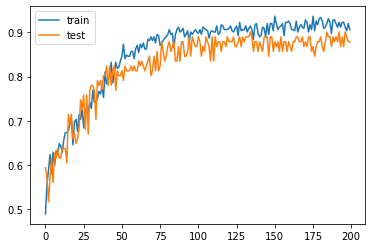

In [22]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


We can see that the improvements are stabilizing, but test and train have similar accuracy, so the is no overfitting, I should try do a more complex neruonal network structure, remove dropouts maybe, and train with more epochs.

4/4 [==============================] - 0s 4ms/step
Accuracy: 0.956
Recall: 0.951


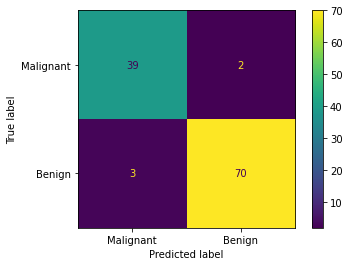

In [23]:
# Evaluate the model
model = keras.models.load_model(checkpoint_path)
y_test = y_test.map({1: "M", 0: "B"})

predictions = model.predict(X_test)
predictions = ["M" if x > 0.5 else "B" for x in predictions]
utils.validation(y_test, predictions)


In this case, the neuronal network is the best model, with just 2 false negatives!

# Ways to improve these results

1. try normalization
2. Control outliers
3. Maybe training with sensitivity is not optimal, we could try to train with accuracy and see the results
4. beter architecture of the neuronal network could improve the results, or more epochs at least.
5. add more samples
6. add more variables